In [ ]:
# import utils as u

In [5]:
import tensorflow_hub as hub

yamnet = hub.load('https://tfhub.dev/google/yamnet/1')

2024-04-26 16:48:57.785123: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-26 16:49:27.150027: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [1]:
import librosa

def load_audio_file(file_path):
    # 加载音频文件，并转换采样率
    wave, sr = librosa.load(file_path, sr=16000, mono=True)
    return wave

# def load_audio_file(file_path, duration=10, sample_rate=16000):
#     # 加载音频文件，并确保音频长度固定为 `duration` 秒
#     audio, sr = librosa.load(file_path, sr=sample_rate, duration=duration)
#     # 如果音频长度小于 `duration`，则进行填充
#     if len(audio) < sample_rate * duration:
#         audio = np.pad(audio, (0, max(0, sample_rate * duration - len(audio))), mode='constant')
    # return audio

In [2]:
def extract_features(audio):
    # YAMNet 返回三个输出：scores, embeddings, spectrogram
    scores, embeddings, spectrogram = yamnet(audio)
    # 根据需要截断或填充 embeddings 以适应模型输入
    max_time_steps = 60  # 假设最大时间步长
    if embeddings.shape[0] < max_time_steps:
        # 填充
        embeddings = np.pad(embeddings, ((0, max_time_steps - embeddings.shape[0]), (0, 0)), 'constant')
    elif embeddings.shape[0] > max_time_steps:
        # 截断
        embeddings = embeddings[:max_time_steps]
    return embeddings

In [35]:
def pitch_shift(audio, sample_rate=22050, pitch_shift_steps=2):
    return librosa.effects.pitch_shift(audio, sr=sample_rate, n_steps=pitch_shift_steps)

In [ ]:
# !pip install audiomentations==0.23.0

In [105]:
from audiomentations import Compose, AddGaussianNoise

def add_bgn(audio, sample_rate=22050):
    noise = Compose([AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5)])
    return noise(audio, sample_rate)

In [120]:
# !pip install pedalboard==0.4.0

from pedalboard import *
def reverb(audio):
    board = Pedalboard([Chorus(), Reverb(room_size=0.25)])
    return board(audio, 22050)

# ladder filter
def lowpass(audio):
    board = Pedalboard([Chorus(),
                    LadderFilter(mode=LadderFilter.Mode.HPF12, cutoff_hz=900)])
    return board(audio, 22050)

In [133]:
import os
import numpy as np

def process_folder(folder_path):
    # 创建一个字典来存储每个文件的 embeddings
    all_embeddings = {}
    # 遍历文件夹中的所有文件
    for filename in os.listdir(folder_path):
        if filename.endswith('.mp3'):  # 确保处理 MP3 文件
            file_path = os.path.join(folder_path, filename)
            audio_original = load_audio_file(file_path)
            audio0 = pitch_shift(audio_original)
            audio1 = add_bgn(audio_original)
            audio2 = reverb(audio_original)
            audio3 = lowpass(audio_original)

            embeddings_ori = extract_features(audio_original)
            embeddings0 = extract_features(audio0)
            embeddings1 = extract_features(audio1)
            embeddings2 = extract_features(audio2)
            embeddings3 = extract_features(audio3)

            all_embeddings[filename] = embeddings_ori # 将 embeddings 转换为 NumPy 数组，并存储
            all_embeddings[filename + '0aug'] = embeddings0
            all_embeddings[filename + '1aug'] = embeddings1
            all_embeddings[filename + '2aug'] = embeddings2
            all_embeddings[filename + '3aug'] = embeddings3

    return all_embeddings

# 指定你的音频文件夹路径
folder_path = '/Users/apple/Documents/DL/Final-project/PMEmo2019/chorus'
# 处理文件夹并获取 embeddings
embeddings_dict = process_folder(folder_path)

/Users/apple/anaconda3/envs/dl4m-final/lib/python3.9/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(


In [ ]:
# import IPython
# IPython.display.Audio()

In [134]:
# 打印所有键
print(list(embeddings_dict.keys()))

['752.mp3', '752.mp30aug', '752.mp31aug', '752.mp32aug', '752.mp33aug', '746.mp3', '746.mp30aug', '746.mp31aug', '746.mp32aug', '746.mp33aug', '791.mp3', '791.mp30aug', '791.mp31aug', '791.mp32aug', '791.mp33aug', '550.mp3', '550.mp30aug', '550.mp31aug', '550.mp32aug', '550.mp33aug', '236.mp3', '236.mp30aug', '236.mp31aug', '236.mp32aug', '236.mp33aug', '222.mp3', '222.mp30aug', '222.mp31aug', '222.mp32aug', '222.mp33aug', '544.mp3', '544.mp30aug', '544.mp31aug', '544.mp32aug', '544.mp33aug', '578.mp3', '578.mp30aug', '578.mp31aug', '578.mp32aug', '578.mp33aug', '587.mp3', '587.mp30aug', '587.mp31aug', '587.mp32aug', '587.mp33aug', '424.mp3', '424.mp30aug', '424.mp31aug', '424.mp32aug', '424.mp33aug', '342.mp3', '342.mp30aug', '342.mp31aug', '342.mp32aug', '342.mp33aug', '356.mp3', '356.mp30aug', '356.mp31aug', '356.mp32aug', '356.mp33aug', '418.mp3', '418.mp30aug', '418.mp31aug', '418.mp32aug', '418.mp33aug', '381.mp3', '381.mp30aug', '381.mp31aug', '381.mp32aug', '381.mp33aug', '395.

In [136]:
# 创建一个新字典，其键是转换后的格式
new_embeddings_dict = {}
for key in embeddings_dict.keys():
    if key[-3:] == 'aug':
        if key[-4] == '0':
            new_key = key[:-8] + ".1"   # for augmentation data, add ".1"
        if key[-4] == '1':
            new_key = key[:-8] + ".2"
        if key[-4] == '2':
            new_key = key[:-8] + ".3"
        if key[-4] == '3':
            new_key = key[:-8] + ".4"    
    else:
        new_key = key[:-4] + ".0"  # 移除 '.mp3' 并添加 '.0'

    new_embeddings_dict[new_key] = embeddings_dict[key]

# embeddings_dict = new_embeddings_dict


In [138]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 加载 Arousal & Valence 数据
av_data = pd.read_csv('/Users/apple/Documents/DL/Final-project/PMEmo2019/annotations/static_annotations.csv')  # 确保路径正确

# 初始化数据列表
X = []
y = []

# 遍历数据行
for index, row in av_data.iterrows():
    music_id = str(row['musicId'])  # 根据需要将 musicId 转换为字符串，假设 embeddings_dict 的键是字符串形式的 musicId
    if music_id in new_embeddings_dict:
        X.append(new_embeddings_dict[music_id])
        X.append(new_embeddings_dict[music_id[:-1] + "1"])
        X.append(new_embeddings_dict[music_id[:-1] + "2"])
        X.append(new_embeddings_dict[music_id[:-1] + "3"])
        X.append(new_embeddings_dict[music_id[:-1] + "4"])
        
        y.append([row['Arousal(mean)'], row['Valence(mean)']])
        y.append([row['Arousal(mean)'], row['Valence(mean)']])
        y.append([row['Arousal(mean)'], row['Valence(mean)']])
        y.append([row['Arousal(mean)'], row['Valence(mean)']])
        y.append([row['Arousal(mean)'], row['Valence(mean)']])

    else:
        print(f"Music ID {music_id} not found in embeddings_dict")  # 输出未找到的音乐 ID

# 将列表转换为 NumPy 数组
X = np.array(X)
y = np.array(y)

print(f"Total samples loaded: {len(X)}")  # 输出加载的样本总数

if len(X) > 0:
    # 划分数据集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Training set size: {len(X_train)}, Test set size: {len(X_test)}")
else:
    print("No data to split. Check your dataset and embeddings.")


Total samples loaded: 3835
Training set size: 3068, Test set size: 767


In [139]:
from tensorflow.keras.models import Sequential
from tcn import TCN, tcn_full_summary
from tensorflow.keras.layers import Dense

def build_model(input_shape):
    model = Sequential([
        TCN(input_shape=input_shape, nb_filters=64, kernel_size=6, nb_stacks=1,
            dilations=[1, 2, 4, 8, 16], padding='causal', use_skip_connections=True,
            dropout_rate=0.0, return_sequences=False, activation='relu', kernel_initializer='he_normal'),
        Dense(2, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# 根据输入数据的形状创建模型
model = build_model(input_shape=(60, 1024))  # 确保这与你的 embeddings 形状匹配



In [143]:
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/5


96/96 [==============================] - 8s 76ms/step - loss: 0.0308 - mae: 0.1443 - val_loss: 0.0320 - val_mae: 0.1468
Epoch 2/5
96/96 [==============================] - 7s 74ms/step - loss: 0.0314 - mae: 0.1461 - val_loss: 0.0378 - val_mae: 0.1512
Epoch 3/5
96/96 [==============================] - 7s 73ms/step - loss: 0.0308 - mae: 0.1448 - val_loss: 0.0331 - val_mae: 0.1531
Epoch 4/5
96/96 [==============================] - 7s 76ms/step - loss: 0.0305 - mae: 0.1438 - val_loss: 0.0319 - val_mae: 0.1486
Epoch 5/5
96/96 [==============================] - 7s 75ms/step - loss: 0.0308 - mae: 0.1447 - val_loss: 0.0321 - val_mae: 0.1503


In [144]:
import matplotlib.pyplot as plt

def plot_loss(history):
    """
    Plot the training and validation loss and mae.

    Parameters
    ----------
    history : keras.callbacks.History
        The history object returned by the `fit` method of a Keras model.

    Returns
    -------
    None
    """
    mae = history.history["mae"]
    val_mae = history.history["val_mae"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(mae) + 1)
    plt.plot(epochs, mae, "bo", label="Training mae")
    plt.plot(epochs, val_mae, "b", label="Validation mae")
    plt.title("Training and validation mae")
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()
    plt.show()

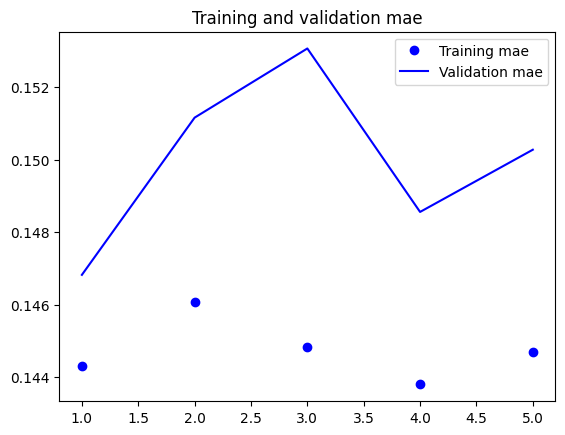

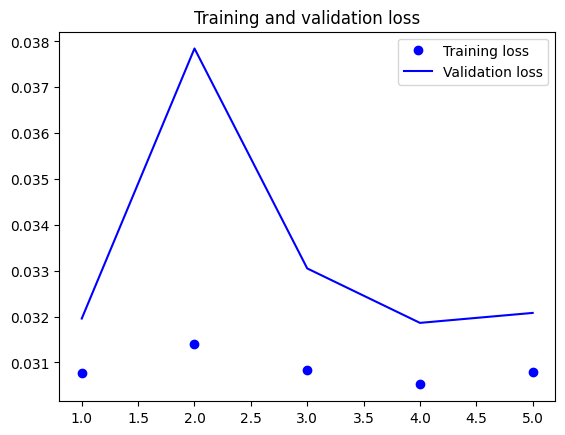

In [145]:
plot_loss(history)

In [146]:
# 评估模型性能
loss, mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test MAE: {mae}')

24/24 [==============================] - 0s 19ms/step - loss: 0.0321 - mae: 0.1503
Test Loss: 0.03208029270172119, Test MAE: 0.15027494728565216


In [18]:
model.save('/Users/apple/Documents/DL/Final-project/emotionPredict.h5')  # 保存为 SavedModel 格式

In [20]:
from tensorflow.keras.models import load_model
from tcn import TCN  # 确保正确导入 TCN 层的定义

# 加载模型时指定自定义层
model_test = load_model('/Users/apple/Documents/DL/Final-project/emotionPredict.h5', custom_objects={'TCN': TCN})

In [21]:
wave, sr = librosa.load("/Users/zhaokaiyang/Documents/24Spring/Deep Learning/Final Project/test.mp3", sr=16000, mono=True)

/var/folders/qg/023t36q10v1dyqpsjpj38v500000gn/T/ipykernel_34290/3485234853.py:1: UserWarning: PySoundFile failed. Trying audioread instead.
  wave, sr = librosa.load("/Users/zhaokaiyang/Documents/24Spring/Deep Learning/Final Project/test.mp3", sr=16000, mono=True)
/Users/apple/anaconda3/envs/dl4m-final/lib/python3.9/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/zhaokaiyang/Documents/24Spring/Deep Learning/Final Project/test.mp3'

In [26]:
feature_test = extract_features(wave)
feature_test = np.expand_dims(feature_test, axis=0)

In [27]:
feature_test.shape

(1, 60, 1024)

In [28]:
predicted_values = model_test.predict(feature_test)

2024-04-23 22:47:00.216681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step


In [30]:
arousal_test, valence_test = predicted_values[0][0], predicted_values[0][1]

In [31]:
print(arousal_test, valence_test)

0.5763612 0.2897878
